In [1]:
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#setting figure size
from matplotlib.pylab import rcParams
rcParams ['figure.figsize'] = 20, 10

In [3]:
#read the file 
df = pd.read_csv('AsianPaints.csv')

In [4]:
df.tail () #see the last data in the file

,Date,Open,High,Low,Last,Close,Total Traded Quantity,Turnover (Lacs)
508,2019-08-02,1509.00,1550.00,1504.50,1548.00,1545.20,3044783,"46,613.43"
509,2019-08-05,1533.20,1551.00,1521.70,1526.60,1525.40,1443728,"22,115.37"
510,2019-08-06,1530.00,1569.85,1524.05,1563.30,1565.85,2056715,"31,981.54"
511,2019-08-07,1563.30,1575.00,1551.90,1559.20,1559.20,1583322,"24,741.51"
512,2019-08-08,1565.75,1569.70,1540.30,1566.05,1565.90,1579565,"24,514.29"


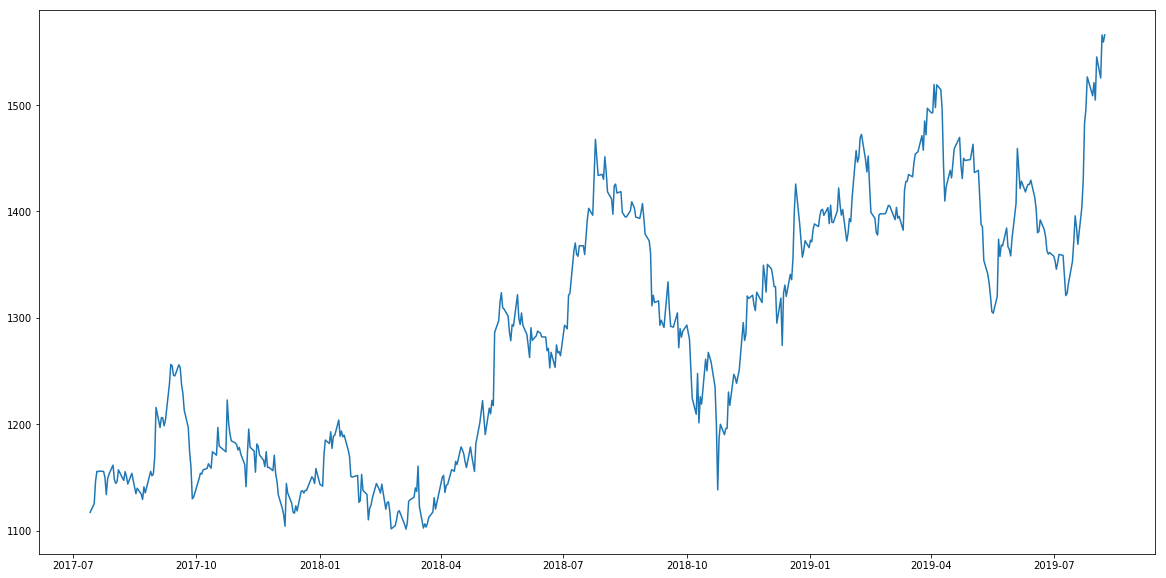

In [5]:
# Setting the index as date
df['Date'] = pd.to_datetime (df.Date, format = '%Y-%m-%d')
df.index = df['Date']

#plot 
plt.plot (df['Close'], label = 'Close Price history')

In [6]:
df.tail()

,Date,Open,High,Low,Last,Close,Total Traded Quantity,Turnover (Lacs)
Date,,,,,,,,
2019-08-02,2019-08-02,1509.00,1550.00,1504.50,1548.00,1545.20,3044783,"46,613.43"
2019-08-05,2019-08-05,1533.20,1551.00,1521.70,1526.60,1525.40,1443728,"22,115.37"
2019-08-06,2019-08-06,1530.00,1569.85,1524.05,1563.30,1565.85,2056715,"31,981.54"
2019-08-07,2019-08-07,1563.30,1575.00,1551.90,1559.20,1559.20,1583322,"24,741.51"
2019-08-08,2019-08-08,1565.75,1569.70,1540.30,1566.05,1565.90,1579565,"24,514.29"


In [7]:
df['Close'].min()

1101.6

##  Long Short Term Memory 

In [8]:
#sklearn required libraries 
from sklearn.preprocessing import MinMaxScaler 
from keras.models import Sequential #import sequential model
from keras.layers import Dense, Dropout, LSTM #import dense, dropout, lstm

Using TensorFlow backend.


In [9]:
# creating dataframe with date and target variable 
data = df.sort_index (ascending = True, axis = 0)
new_data = pd.DataFrame (index = range(0, len(df)), columns = ['Date', 'Close'])

for i in range (0, len(data)):
    new_data['Date'][i] = data ['Date'][i]
    new_data['Close'][i] = data ['Close'][i]

In [10]:
new_data.index = new_data.Date  #index set to date
new_data.drop ('Date', axis = 1, inplace = True)

In [11]:
new_data.head ()

,Close
Date,
2017-07-14,1117.35
2017-07-17,1125.45
2017-07-18,1146.6
2017-07-19,1155.85
2017-07-20,1155.55


In [12]:
#creating training and testing data
dataset = new_data.values #we are taking the close price value as out stock predictions will be based on that given data

train = dataset [0:400, :]
valid = dataset[400:, :]

In [13]:
valid.shape

(113, 1)

In [14]:
#converting dataset into x_train and y_train
# Normalizing the data, i.e., converting it into a scale of 0 to 1
scaler = MinMaxScaler (feature_range = (0, 1))
scaled_data = scaler.fit_transform (dataset)

x_train, y_train = [], []
for i in range (60, len(train)):
    x_train.append (scaled_data[i-60:i, 0])
    y_train.append (scaled_data[i, 0])

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [15]:
x_train, y_train = np.array (x_train), np.array (y_train)

In [16]:
x_train.shape

(340, 60)

In [17]:
x_train = np.reshape (x_train, (x_train.shape[0], x_train.shape[1], 1))

In [18]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/1
 - 24s - loss: 0.0076


In [19]:
#predicting 246 values, using past 60 from the train data
inputs = new_data [len(new_data) - len(valid) - 60:].values 
inputs = inputs.reshape (-1, 1)
inputs = scaler.transform (inputs)

X_test = []
for i in range (60, inputs.shape[0]):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array (X_test)

In [20]:
X_test.shape

(113, 60)

In [21]:
X_test = np.reshape (X_test, (X_test.shape[0], X_test.shape[1], 1))

In [22]:
X_test.shape

(113, 60, 1)

In [23]:
closing_price = model.predict (X_test)
closing_price = scaler.inverse_transform (closing_price)

In [24]:
valid.shape

(113, 1)

In [25]:
closing_price.shape

(113, 1)

In [26]:
rms = np.sqrt (np.mean (np.power((valid-closing_price), 2)))
rms

44.419045380421245

C:\Users\hp\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


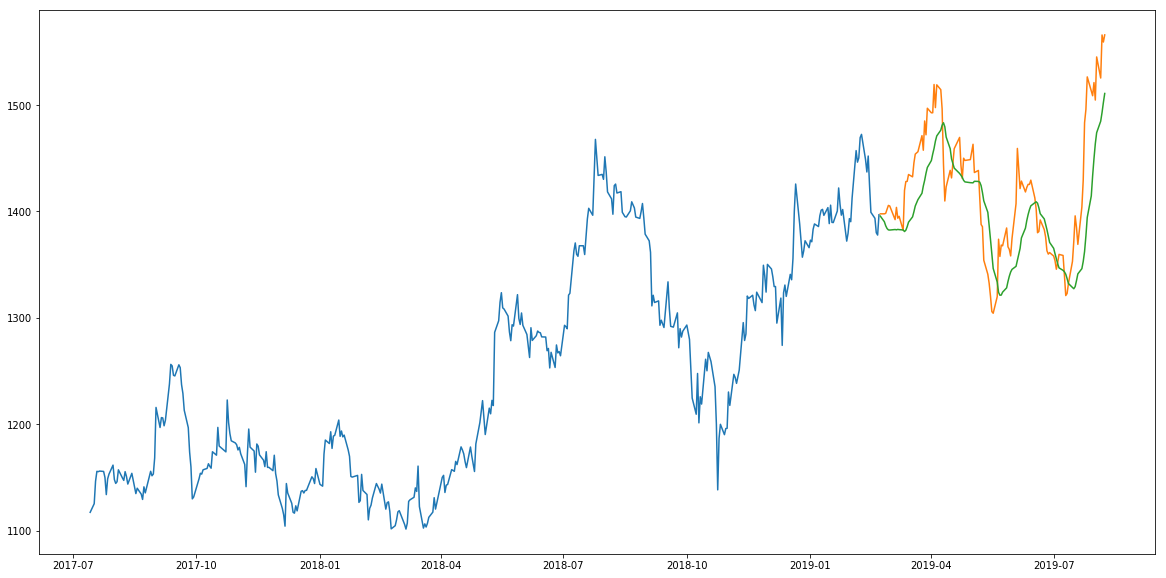

In [27]:
#for plotting
train = new_data[:400]
valid = new_data[400:]
valid['Predictions'] = closing_price
plt.plot (train['Close'])
plt.plot (valid[['Close', 'Predictions']])